In this notebook i'll apply ML algorithms for larceny occurrences in the Boston Crime Incidents dataset.

The dataset was preprocessed here: https://github.com/RaphaelRoriz/Machine_learning/blob/master/CrimeBoston/BostonCrime%20cleaning%20and%20analysis.ipynb

The original dataset can be downloaded here: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
from noOccurrence_generator import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score  
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [3]:
#show the number of correct classification for both classes and the overall misclassification.
def compare_classPredictions(target,predicted):
    correct_class0 = correct_class1 = 0 #number of correct classifications for both classes
    dataSize = len(target)
    for i in range(0,dataSize):
        targetAux = target[i]
        if targetAux == 0 and targetAux == predicted[i]:
            correct_class0 +=1
        elif targetAux == 1 and targetAux == predicted[i]:
            correct_class1+=1
        else:
            pass
        
    print("Number of class 0 corrected classified: ",correct_class0)
    print("Number of class 1 corrected classified: ",correct_class1)
    print("Missclassified:", dataSize - (correct_class0+correct_class1))
            

# Importing dataset and generating synthetic entries

In [4]:
df = pd.read_csv('larcenyData.csv',encoding='latin1')

In [5]:
df

,Unnamed: 0,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,54,Larceny,C6,2019,9,7,3,42.340070,-71.052794
1,79,Larceny,D4,2019,9,6,23,42.344396,-71.086320
2,123,Larceny,E13,2019,9,6,20,42.319293,-71.111782
3,129,Larceny,C11,2019,9,6,19,42.291265,-71.068114
4,131,Larceny,C11,2019,9,6,19,42.295263,-71.072074
...,...,...,...,...,...,...,...,...,...
33613,426828,Larceny,D4,2016,6,7,17,42.336951,-71.085748
33614,426829,Larceny,D4,2016,6,7,17,42.336951,-71.085748
33615,426847,Larceny,B2,2018,12,4,0,42.309563,-71.089902
33616,426848,Larceny,B2,2018,12,4,0,42.309563,-71.089902


In [6]:
df.drop('Unnamed: 0',axis = 1, inplace=True)

We only have entries for occurrences in the dataset, so i created a no ocurrence generator, so we can train  classification algorithms with the data.

generator: https://github.com/RaphaelRoriz/Machine_learning/blob/master/CrimeBoston/noOccurrence_generator.py

In [7]:
#no-occurred entries generated from noOccurrence_generator
dfSynthetized = gen_syntheticData(len(df))

In [8]:
dfSynthetized

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,not occurred,B3,2018,10,4,6,42.276782,-71.081674
1,not occurred,E5,2016,1,2,6,42.346029,-71.109963
2,not occurred,E13,2017,5,1,22,42.380403,-70.979110
3,not occurred,E5,2017,7,6,12,42.251491,-71.074359
4,not occurred,A7,2018,10,4,15,42.300535,-71.023347
...,...,...,...,...,...,...,...,...
33613,not occurred,E5,2017,4,3,4,42.268043,-71.126471
33614,not occurred,A1,2018,6,2,5,42.279320,-71.172660
33615,not occurred,E13,2017,3,3,20,42.285856,-71.015634
33616,not occurred,E18,2018,5,7,1,42.385456,-70.968439


In [9]:
#dataset containing the larceny occurrencies and the synthetic no-occurrence data
larceny = pd.concat([df,dfSynthetized],axis = 0)

In [10]:
larceny

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,Larceny,C6,2019,9,7,3,42.340070,-71.052794
1,Larceny,D4,2019,9,6,23,42.344396,-71.086320
2,Larceny,E13,2019,9,6,20,42.319293,-71.111782
3,Larceny,C11,2019,9,6,19,42.291265,-71.068114
4,Larceny,C11,2019,9,6,19,42.295263,-71.072074
...,...,...,...,...,...,...,...,...
33613,not occurred,E5,2017,4,3,4,42.268043,-71.126471
33614,not occurred,A1,2018,6,2,5,42.279320,-71.172660
33615,not occurred,E13,2017,3,3,20,42.285856,-71.015634
33616,not occurred,E18,2018,5,7,1,42.385456,-70.968439


# Target column generation

- 1 = larceny occurrence
- 0 = no occurrence

In [11]:
def get_class(offense):
    #return the class of the occurrence: 1-> a larceny occurred 0-> no larceny occurrence
    if(offense == 'Larceny'):
        return 1
    else:
        return 0

In [12]:
larceny['occurred'] = larceny['OFFENSE_CODE_GROUP'].apply(get_class)

In [13]:
larceny

,OFFENSE_CODE_GROUP,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,occurred
0,Larceny,C6,2019,9,7,3,42.340070,-71.052794,1
1,Larceny,D4,2019,9,6,23,42.344396,-71.086320,1
2,Larceny,E13,2019,9,6,20,42.319293,-71.111782,1
3,Larceny,C11,2019,9,6,19,42.291265,-71.068114,1
4,Larceny,C11,2019,9,6,19,42.295263,-71.072074,1
...,...,...,...,...,...,...,...,...,...
33613,not occurred,E5,2017,4,3,4,42.268043,-71.126471,0
33614,not occurred,A1,2018,6,2,5,42.279320,-71.172660,0
33615,not occurred,E13,2017,3,3,20,42.285856,-71.015634,0
33616,not occurred,E18,2018,5,7,1,42.385456,-70.968439,0


In [14]:
larceny.drop('OFFENSE_CODE_GROUP',axis = 1, inplace=True)

# Shuffle the dataset 

In [15]:
larceny = larceny.sample(frac=1).reset_index(drop=True)

In [16]:
larceny

,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,occurred
0,D4,2018,11,4,12,42.348624,-71.082776,1
1,C11,2018,9,2,0,42.354339,-71.079124,0
2,D4,2017,11,3,10,42.342115,-71.066111,1
3,D4,2016,8,4,18,42.235122,-71.118598,0
4,C6,2019,6,5,13,42.326921,-71.058419,1
...,...,...,...,...,...,...,...,...
67231,D14,2017,5,5,11,42.347747,-71.153455,1
67232,C11,2017,2,6,21,42.364675,-70.990376,0
67233,E18,2017,4,3,20,42.277316,-71.013136,0
67234,B2,2017,7,2,12,42.316966,-71.082541,1


# Dummy variables

In [17]:
larceny = pd.get_dummies(larceny,columns=['DISTRICT'],drop_first=True)

In [18]:
larceny.columns

Index(['YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Lat', 'Long', 'occurred',
       'DISTRICT_A15', 'DISTRICT_A7', 'DISTRICT_B2', 'DISTRICT_B3',
       'DISTRICT_C11', 'DISTRICT_C6', 'DISTRICT_D14', 'DISTRICT_D4',
       'DISTRICT_E13', 'DISTRICT_E18', 'DISTRICT_E5'],
      dtype='object')

In [19]:
larceny

,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,occurred,DISTRICT_A15,DISTRICT_A7,DISTRICT_B2,DISTRICT_B3,DISTRICT_C11,DISTRICT_C6,DISTRICT_D14,DISTRICT_D4,DISTRICT_E13,DISTRICT_E18,DISTRICT_E5
0,2018,11,4,12,42.348624,-71.082776,1,0,0,0,0,0,0,0,1,0,0,0
1,2018,9,2,0,42.354339,-71.079124,0,0,0,0,0,1,0,0,0,0,0,0
2,2017,11,3,10,42.342115,-71.066111,1,0,0,0,0,0,0,0,1,0,0,0
3,2016,8,4,18,42.235122,-71.118598,0,0,0,0,0,0,0,0,1,0,0,0
4,2019,6,5,13,42.326921,-71.058419,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67231,2017,5,5,11,42.347747,-71.153455,1,0,0,0,0,0,0,1,0,0,0,0
67232,2017,2,6,21,42.364675,-70.990376,0,0,0,0,0,1,0,0,0,0,0,0
67233,2017,4,3,20,42.277316,-71.013136,0,0,0,0,0,0,0,0,0,0,1,0
67234,2017,7,2,12,42.316966,-71.082541,1,0,0,1,0,0,0,0,0,0,0,0


# EDA

<Figure size 1080x720 with 0 Axes>

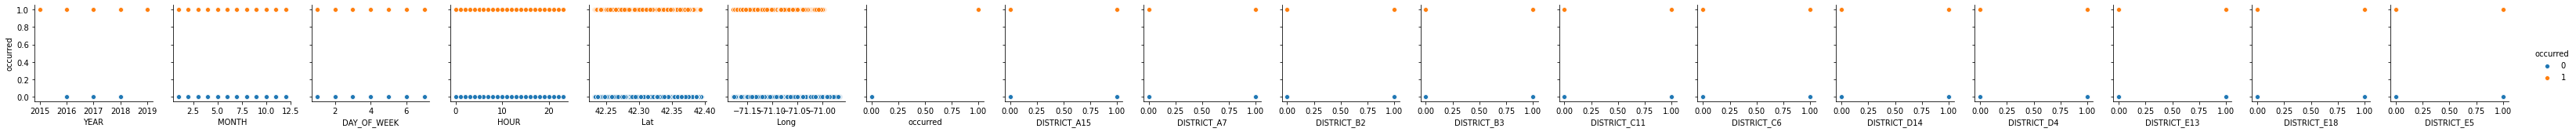

In [20]:
xVars = larceny.columns.tolist()
plt.figure(figsize=(15,10))
sns.pairplot(data = larceny,hue = "occurred",y_vars=['occurred'],x_vars=xVars)

# Train and test sets split

In [21]:
y = larceny['occurred']
X = larceny.drop(['occurred','YEAR'],axis = 1) #i'll remove the YEAR column,so it wont affect the model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## KFold

In [23]:
kfold = KFold(n_splits=5,shuffle=True,random_state=116)

# Evaluating models

## Defining models

### 1)KNN

In [24]:
knnPipeline = Pipeline(steps=[
    ('scalar',StandardScaler()),
    ('model',KNeighborsClassifier())
]
)

### 2) Random Forest 

In [25]:
rfcPipeline = Pipeline(steps=[
    ('model',RandomForestClassifier())
]
)

### XGBoost

In [26]:
xgbPipeline = Pipeline(steps=[
    ('model',xgb.XGBClassifier())
]
)

## Evaluate

In [27]:
models = [
    ('knn',knnPipeline),
    ('rfc',rfcPipeline),
    ('xgb',xgbPipeline)
]

In [28]:
results = {}
names = []
scoring = 'accuracy'

In [32]:
#perform a cross validation for every model and store the results
for name,model in models:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results[name] = cv_results

In [33]:
results

{'knn': array([0.93039857, 0.93359114, 0.93522719, 0.93098832, 0.9334424 ]),
 'rfc': array([0.96958656, 0.97211274, 0.97248457, 0.97003049, 0.97151781]),
 'xgb': array([0.97754313, 0.97545921, 0.97895441, 0.97575667, 0.97642597])}

In [34]:
average_results = {}
for key in results.keys():
    average_results[key] = np.sqrt(results[key]).sum()/5

In [35]:
average_results

{'knn': 0.9657787891383386,
 'rfc': 0.9854674505304072,
 'xgb': 0.9883458194368531}

## Comparing predictions results and scores for the best model.

In [36]:
xgbPipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight...cale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None))])

In [37]:
#predictions
train_predictions = xgbPipeline.predict(X_train)
test_predictions =xgbPipeline.predict(X_test)

In [38]:
xgbPipeline.score(X_train,y_train)

0.9854244130457878

In [39]:
xgbPipeline.score(X_test,y_test)

0.9796242129790294

In [40]:
compare_classPredictions(y_train.tolist(),train_predictions.tolist())

Number of class 0 corrected classified:  22989
Number of class 1 corrected classified:  23390
Missclassified: 686


In [41]:
compare_classPredictions(y_test.tolist(),test_predictions.tolist())

Number of class 0 corrected classified:  9737
Number of class 1 corrected classified:  10023
Missclassified: 411


In [42]:
confusion_matrix(y_train, train_predictions)

array([[22989,   580],
       [  106, 23390]])

In [43]:
confusion_matrix(y_test,test_predictions)

array([[ 9737,   312],
       [   99, 10023]])

## Improving the XGBoost performance 

In [58]:
#parameters for hyperparameter tuning
params = {
 "model__learning_rate"    : [0.01, 0.05, 0.1, 0.15, 0.20 ] ,
 "model__max_depth"        : [ 3,5,7,9,11,13],
 "model__min_child_weight" : [ 1, 3, 5, 7 ],
 "model__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "model__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] 
}

In [59]:
grid = GridSearchCV(estimator=xgbPipeline, param_grid=params, scoring=scoring, n_jobs=2, cv=kfold )

In [61]:
#grid.fit(X_train,y_train)

In [ ]:
train_predictions_gS = grid.predict(X_train)
test_predictions_gS = grid.predict(X_test)

In [ ]:
grid.score(X_train,y_train)

In [ ]:
grid.score(X_train,y_train)

In [ ]:
compare_classPredictions(y_train.tolist(),train_predictions_gS.tolist())

In [ ]:
compare_classPredictions(y_test.tolist(),test_predictions_gS.tolist())